<a href="https://colab.research.google.com/github/TheCaveOfAdullam/2026-reserch-1/blob/main/A_KdDPP_11kw_simori_new_super.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_pruning
!pip install ptflops
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=b9f0efef9b17e8fd8212286ea7274d638238a608af3a6c0363e5d7f0e1874209
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=e05cc726cc2df0e9cb943ccd67016a262630a1cf28d91ceed0d4c1b6a0ae4e9b
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F # 추가됨.
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
import torch.nn.utils.prune as prune
import torch_pruning as tp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
from ptflops import get_model_complexity_info
import time
import random

In [ ]:
seed = 51
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # GPU 사용 시
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM', 'fault_BELT']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 저장된 데이터 로딩용 Dataset =====
class PreprocessedDataset(Dataset):
    def __init__(self, pt_file):
        data = torch.load(pt_file, weights_only=False)
        self.X = data['X']
        self.y = data['y']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].T
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# ===== CSV 읽기 없이 바로 로딩 =====
train_dataset = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/train_processed.pt')
val_dataset   = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/val_processed.pt')
test_dataset  = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/test_processed.pt')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

print("빠른 데이터 로딩 완료!")

빠른 데이터 로딩 완료!


In [ ]:
# 첫 번째 데이터의 크기를 이용해 input_length 결정
first_sample, _ = train_dataset[0]
input_length = first_sample.shape[1]  # X는 (채널, 길이) 형태이므로 길이는 첫 번째 데이터의 두 번째 차원
print(f"Input length for one sample: {input_length}")

Input length for one sample: 1500


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_length):
        super(CNNModel, self).__init__()

        # --- Convolution layers ---
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # --- Flatten 후 크기 계산 ---
        with torch.no_grad():
            sample_input = torch.zeros(1, 1, input_length)
            sample_output = self.forward_conv_layers(sample_input)
            conv_output_size = sample_output.size(1) * sample_output.size(2)

        # --- Fully Connected ---
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.dropout = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, len(categories))

    def forward_conv_layers(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self.forward_conv_layers(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.bn1(x)
        x = self.fc2(x)
        return x

In [ ]:
# -------------------------------
# 학습 도우미 함수
# -------------------------------
def distillation_loss(student_logits, teacher_logits, labels, T=4.0, alpha=0.7):
    soft_loss = nn.KLDivLoss(reduction="batchmean")(nn.functional.log_softmax(student_logits / T, dim=1),
                                                    nn.functional.softmax(teacher_logits / T, dim=1))
    hard_loss = nn.CrossEntropyLoss()(student_logits, labels)
    return alpha * hard_loss + (1 - alpha) * (T * T) * soft_loss


In [ ]:
# -------------------------------
# 지식 증류 기반 Student 모델 학습 함수
# -------------------------------
def train_kd(student_model, teacher_model, train_loader, val_loader, optimizer, num_epochs=10, T=4.0, alpha=0.7):
    student_model.to(device)
    teacher_model.to(device)
    teacher_model.eval()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        student_model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_iter = tqdm(train_loader, desc=f"KD Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
            student_outputs = student_model(inputs)
            loss = distillation_loss(student_outputs, teacher_outputs, labels, T=T, alpha=alpha)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(student_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(student_model, val_loader, nn.CrossEntropyLoss())
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"KD Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('KD - Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('KD - Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# 학습 및 검증 손실, 정확도 기록을 위한 train_model 함수 수정
def train_teacher_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 학습 및 검증 손실, 정확도 기록용 리스트
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm을 사용하여 진행 상황을 표시
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 현재 배치의 손실과 정확도를 tqdm에 표시
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        # Training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation evaluation
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)[:2]

        # 기록용 리스트에 추가
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return model

In [ ]:
# 학습 및 검증 손실, 정확도 기록을 위한 train_model 함수 수정
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 학습 및 검증 손실, 정확도 기록용 리스트
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm을 사용하여 진행 상황을 표시
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 현재 배치의 손실과 정확도를 tqdm에 표시
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        # Training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation evaluation
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)[:2]

        # 기록용 리스트에 추가
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

# 학습 곡선 시각화 함수 (전체 학습 곡선 통합)
def plot_combined_learning_curves(total_train_losses, total_val_losses, total_train_accuracies, total_val_accuracies):
    epochs = range(1, len(total_train_losses) + 1)

    # 손실 곡선
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, total_train_losses, label='Train Loss')
    plt.plot(epochs, total_val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Combined Training and Validation Loss')
    plt.legend()

    # 정확도 곡선
    plt.subplot(1, 2, 2)
    plt.plot(epochs, total_train_accuracies, label='Train Accuracy')
    plt.plot(epochs, total_val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Combined Training and Validation Accuracy')
    plt.legend()

    plt.show()

In [ ]:
# 모델 평가 함수
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 샘플 수 기반의 loss 계산
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 전체 샘플 수로 나눔 → 샘플 평균 Loss
    average_val_loss = val_loss / total
    val_accuracy = 100 * correct / total

    return average_val_loss, val_accuracy

In [ ]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    model_size = (param_size + buffer_size) / 1024**2  # Convert to MB

    if model_size < 1.0:
        return model_size * 1024, "KB"   # KB로 변환하여 반환
    else:
        return model_size, "MB"          # MB 단위 그대로 반환

In [ ]:
# F1 스코어 계산
def calculate_f1_score(model, loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"F1 Score: {f1:.4f}")

In [ ]:
# 1차 테일러 전개 기반 비구조적 프루닝 (마스크 없이)
def prune_by_taylor(model, threshold=0.01):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            if module.weight.grad is None:
                raise ValueError(f"Gradients not found for {name}. Run backward pass before pruning.")

            # 가중치 중요도를 계산하고 threshold 이하의 값들을 0으로 설정
            importance = torch.abs(module.weight * module.weight.grad)
            with torch.no_grad():
                module.weight[importance < threshold] = 0
    print(f"Taylor expansion-based pruning with threshold: {threshold} applied.")

# 0 비율 기반 필터 감지 및 구조적 프루닝 적용 함수
def detect_and_apply_structural_pruning_with_zero_ratio(model, prune_threshold=0.7, example_inputs=None):
    if example_inputs is None:
        example_inputs = torch.randn(1, 1, input_length).to(next(model.parameters()).device)  # 입력 채널을 1로 설정

    DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)
    total_pruned = 0

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            # **출력 레이어는 프루닝 대상에서 제외**
            if name == 'fc2':
                print(f"Skipping pruning for {name} (output layer).")
                continue

            # 필터/뉴런의 0 비율 계산 및 프루닝 대상 선정
            weight_data = module.weight.detach().cpu().numpy()
            if isinstance(module, nn.Conv1d):
                filter_zero_percentage = np.mean(weight_data == 0, axis=(1, 2))
            else:
                filter_zero_percentage = np.mean(weight_data == 0, axis=1)
            prune_indices = np.where(filter_zero_percentage >= prune_threshold)[0]

            # 프루닝 대상 필터/뉴런 제거
            if len(prune_indices) > 0 and len(prune_indices) < module.weight.shape[0]:
                pruning_group = None
                if isinstance(module, nn.Conv1d):
                    pruning_group = DG.get_pruning_group(module, tp.prune_conv_out_channels, idxs=prune_indices)
                elif isinstance(module, nn.Linear):
                    pruning_group = DG.get_pruning_group(module, tp.prune_linear_out_channels, idxs=prune_indices)

                if pruning_group is not None:
                    pruning_group.prune()
                    total_pruned += len(prune_indices)
                    print(f"Pruned {len(prune_indices)} filters/neuron(s) from {name}.")
            else:
                print(f"Skipping pruning for {name} as it would remove all filters/neuron(s).")

    print(f"Structural pruning based on zero ratio applied. {total_pruned} filters/neuron(s) pruned in total.")
    return model

In [ ]:
# 프루닝 및 재훈련 과정 함수 수정
def prune_and_retrain(model, teacher_model, train_loader, val_loader, test_loader, criterion, device, optimizer_params, threshold_taylor=0.01, prune_threshold=0.7):
    # 초기 옵티마이저 설정
    optimizer = optim.Adam(model.parameters(), **optimizer_params)

    # 초기 훈련
    print("Initial training before pruning")
    init_train_losses, init_val_losses, init_train_accuracies, init_val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

    # Step 1: Taylor 전개 기반 비구조적 프루닝
    print("Step 1: Taylor expansion-based pruning")
    # 프루닝을 위해 한 번의 forward 및 backward 패스를 수행하여 그래디언트 계산
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        break  # 한 배치만 필요함

    # 마스크 없이 Taylor 기반 프루닝 적용
    prune_by_taylor(model, threshold_taylor)

    # Step 2: 0 비율 기반 구조적 프루닝
    print("Step 2: Structural pruning based on zero ratio")
    model = detect_and_apply_structural_pruning_with_zero_ratio(model, prune_threshold=prune_threshold)

    # # 프루닝 후 재학습(지식 증류)
    # optimizer = optim.Adam(model.parameters(), **optimizer_params)
    # print("Retraining after pruning")
    # retrain_train_losses, retrain_val_losses, retrain_train_accuracies, retrain_val_accuracies = train_kd(
    #     model, teacher_model, train_loader, val_loader, optimizer, num_epochs=11, T=3.5, alpha=0.65)

    # 프루닝 후 재학습
    optimizer = optim.Adam(model.parameters(), **optimizer_params)
    print("Retraining after pruning")
    retrain_train_losses, retrain_val_losses, retrain_train_accuracies, retrain_val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

    # 초기 훈련 및 재훈련의 손실과 정확도를 결합
    total_train_losses = init_train_losses + retrain_train_losses
    total_val_losses = init_val_losses + retrain_val_losses
    total_train_accuracies = init_train_accuracies + retrain_train_accuracies
    total_val_accuracies = init_val_accuracies + retrain_val_accuracies

    # 통합 학습 곡선 시각화
    plot_combined_learning_curves(total_train_losses, total_val_losses, total_train_accuracies, total_val_accuracies)

    # 테스트 셋에 대한 최종 평가
    print("Final evaluation on the test set...")
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

    return model

In [ ]:
# Teacher 모델 초기화 및 가중치 로드
teacher_model = CNNModel(input_length=input_length).to(device)
criterion = nn.CrossEntropyLoss().to(device)

# 가중치를 모델과 같은 디바이스로 불러오기
teacher_model.load_state_dict(
     torch.load("/content/drive/MyDrive/new model 11kw/teacher_model_2.pth", map_location=device))

teacher_model.eval()  # Teacher는 추론 전용

CNNModel(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11968, out_features=256, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

In [ ]:
# teacher_model 정확도
print("Final evaluation on the test set...")
test_loss, test_accuracy = evaluate_model(teacher_model, test_loader, criterion)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

Final evaluation on the test set...
Final Test Loss: 0.0130, Final Test Accuracy: 99.68%


In [ ]:
# 파라미터 설정 및 프루닝 실행
model = CNNModel(input_length=input_length).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_params = {'lr': 1e-5, 'weight_decay': 8e-5}

In [ ]:
model_size = get_model_size(model)

size, unit = get_model_size(model)
print(f"Model size: {size:.2f} {unit}")

Model size: 11.73 MB


In [ ]:
# 비제로 가중치 계산 함수
def count_nonzero_weights(model):
    nonzero_count = 0
    total_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            nonzero_count += torch.sum(param != 0).item()  # 0이 아닌 가중치 수 계산
            total_count += param.numel()  # 전체 가중치 수 계산
    return nonzero_count, total_count

# 비제로 가중치 수 계산
nonzero_weights, total_weights = count_nonzero_weights(model)
print(f"Number of non-zero weights: {nonzero_weights}")
print(f"Total number of weights: {total_weights}")
print(f"Percentage of non-zero weights: {100 * nonzero_weights / total_weights:.2f}%")

Number of non-zero weights: 3073444
Total number of weights: 3073701
Percentage of non-zero weights: 99.99%


Initial training before pruning


Epoch 1/5: 100%|██████████| 2625/2625 [00:19<00:00, 135.99batch/s, accuracy=58.2, loss=0.934]


Epoch [1/5], Loss: 1.0898, Accuracy: 58.21%, Val Loss: 0.9430, Val Accuracy: 61.05%


Epoch 2/5: 100%|██████████| 2625/2625 [00:18<00:00, 139.47batch/s, accuracy=82.7, loss=0.75]


Epoch [2/5], Loss: 0.7574, Accuracy: 82.73%, Val Loss: 0.7143, Val Accuracy: 80.39%


Epoch 3/5: 100%|██████████| 2625/2625 [00:19<00:00, 131.90batch/s, accuracy=93.1, loss=0.377]


Epoch [3/5], Loss: 0.5071, Accuracy: 93.11%, Val Loss: 0.5843, Val Accuracy: 90.38%


Epoch 4/5: 100%|██████████| 2625/2625 [00:19<00:00, 137.25batch/s, accuracy=97.8, loss=0.238]


Epoch [4/5], Loss: 0.3469, Accuracy: 97.82%, Val Loss: 0.4814, Val Accuracy: 88.54%


Epoch 5/5: 100%|██████████| 2625/2625 [00:18<00:00, 141.47batch/s, accuracy=98.8, loss=0.127]


Epoch [5/5], Loss: 0.2315, Accuracy: 98.80%, Val Loss: 0.4044, Val Accuracy: 86.73%
Step 1: Taylor expansion-based pruning
Taylor expansion-based pruning with threshold: 8e-06 applied.
Step 2: Structural pruning based on zero ratio
Pruned 3 filters/neuron(s) from conv1.
Pruned 7 filters/neuron(s) from conv2.
Pruned 10 filters/neuron(s) from conv3.
Pruned 244 filters/neuron(s) from fc1.
Skipping pruning for fc2 (output layer).
Structural pruning based on zero ratio applied. 264 filters/neuron(s) pruned in total.
Retraining after pruning


Epoch 1/15: 100%|██████████| 2625/2625 [00:17<00:00, 152.65batch/s, accuracy=80.3, loss=0.966]


Epoch [1/15], Loss: 1.0870, Accuracy: 80.33%, Val Loss: 1.1260, Val Accuracy: 75.96%


Epoch 2/15: 100%|██████████| 2625/2625 [00:16<00:00, 157.41batch/s, accuracy=86, loss=0.911]


Epoch [2/15], Loss: 0.9555, Accuracy: 86.00%, Val Loss: 0.9785, Val Accuracy: 85.23%


Epoch 3/15: 100%|██████████| 2625/2625 [00:16<00:00, 156.43batch/s, accuracy=88.2, loss=0.863]


Epoch [3/15], Loss: 0.8520, Accuracy: 88.25%, Val Loss: 0.8912, Val Accuracy: 92.47%


Epoch 4/15: 100%|██████████| 2625/2625 [00:17<00:00, 150.02batch/s, accuracy=89.5, loss=0.742]


Epoch [4/15], Loss: 0.7637, Accuracy: 89.53%, Val Loss: 0.8371, Val Accuracy: 85.85%


Epoch 5/15: 100%|██████████| 2625/2625 [00:16<00:00, 155.55batch/s, accuracy=90.1, loss=0.691]


Epoch [5/15], Loss: 0.6909, Accuracy: 90.14%, Val Loss: 0.7185, Val Accuracy: 89.46%


Epoch 6/15: 100%|██████████| 2625/2625 [00:17<00:00, 152.79batch/s, accuracy=90.8, loss=0.584]


Epoch [6/15], Loss: 0.6234, Accuracy: 90.77%, Val Loss: 0.6558, Val Accuracy: 89.93%


Epoch 7/15: 100%|██████████| 2625/2625 [00:17<00:00, 152.04batch/s, accuracy=91, loss=0.457]


Epoch [7/15], Loss: 0.5670, Accuracy: 90.99%, Val Loss: 0.5800, Val Accuracy: 93.82%


Epoch 8/15: 100%|██████████| 2625/2625 [00:17<00:00, 152.32batch/s, accuracy=91.4, loss=0.546]


Epoch [8/15], Loss: 0.5178, Accuracy: 91.38%, Val Loss: 0.5157, Val Accuracy: 96.42%


Epoch 9/15: 100%|██████████| 2625/2625 [00:17<00:00, 152.25batch/s, accuracy=91.5, loss=0.504]


Epoch [9/15], Loss: 0.4766, Accuracy: 91.46%, Val Loss: 0.4296, Val Accuracy: 99.53%


Epoch 10/15: 100%|██████████| 2625/2625 [00:17<00:00, 150.11batch/s, accuracy=91.7, loss=0.513]


Epoch [10/15], Loss: 0.4414, Accuracy: 91.70%, Val Loss: 0.4138, Val Accuracy: 95.17%


Epoch 11/15: 100%|██████████| 2625/2625 [00:17<00:00, 153.60batch/s, accuracy=91.9, loss=0.527]


Epoch [11/15], Loss: 0.4078, Accuracy: 91.95%, Val Loss: 0.3471, Val Accuracy: 98.63%


Epoch 12/15: 100%|██████████| 2625/2625 [00:17<00:00, 151.66batch/s, accuracy=92, loss=0.323]


Epoch [12/15], Loss: 0.3812, Accuracy: 92.00%, Val Loss: 0.3401, Val Accuracy: 98.66%


Epoch 13/15: 100%|██████████| 2625/2625 [00:17<00:00, 148.46batch/s, accuracy=92, loss=0.367]


Epoch [13/15], Loss: 0.3611, Accuracy: 92.02%, Val Loss: 0.3116, Val Accuracy: 96.37%


Epoch 14/15: 100%|██████████| 2625/2625 [00:17<00:00, 152.59batch/s, accuracy=92.4, loss=0.377]


Epoch [14/15], Loss: 0.3379, Accuracy: 92.37%, Val Loss: 0.2757, Val Accuracy: 96.64%


Epoch 15/15: 100%|██████████| 2625/2625 [00:17<00:00, 152.28batch/s, accuracy=92.4, loss=0.328]


Epoch [15/15], Loss: 0.3227, Accuracy: 92.43%, Val Loss: 0.3466, Val Accuracy: 91.91%


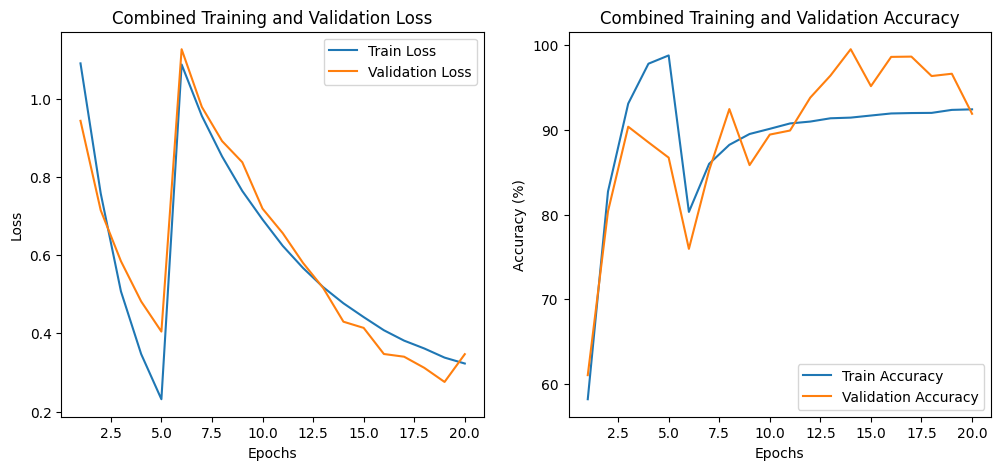

Final evaluation on the test set...
Final Test Loss: 0.3269, Final Test Accuracy: 93.63%


In [ ]:
model = prune_and_retrain(model, teacher_model, train_loader, val_loader, test_loader, criterion, device, optimizer_params, threshold_taylor=8e-6, prune_threshold=0.5)

In [ ]:
# 최종 테스트 평가
print("Final evaluation on the test set...")
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

Final evaluation on the test set...
Final Test Loss: 0.3269, Final Test Accuracy: 93.63%


In [ ]:
model_size = get_model_size(model)

size, unit = get_model_size(model)
print(f"Model size: {size:.2f} {unit}")

Model size: 493.98 KB


In [ ]:
# 모델 저장
torch.save(model.state_dict(), "pruned_model.pth")

# 파일 크기 확인
file_size = os.path.getsize("pruned_model.pth") / 1024**2  # MB로 변환
print(f"모델 크기: {file_size:.2f} MB")

모델 크기: 0.49 MB


In [ ]:
# 모델 저장
torch.save(model.state_dict(), "pruned_model.pth")

# 파일 크기 확인
file_size = os.path.getsize("pruned_model.pth") / 1024  # KB로 변환
print(f"모델 크기: {file_size:.2f} KB")

모델 크기: 499.16 KB


In [ ]:
# 비제로 가중치 계산 함수
def count_nonzero_weights(model):
    nonzero_count = 0
    total_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            nonzero_count += torch.sum(param != 0).item()  # 0이 아닌 가중치 수 계산
            total_count += param.numel()  # 전체 가중치 수 계산
    return nonzero_count, total_count

# 비제로 가중치 수 계산
nonzero_weights, total_weights = count_nonzero_weights(model)
print(f"Number of non-zero weights: {nonzero_weights}")
print(f"Total number of weights: {total_weights}")
print(f"Percentage of non-zero weights: {100 * nonzero_weights / total_weights:.2f}%")

Number of non-zero weights: 125221
Total number of weights: 126433
Percentage of non-zero weights: 99.04%


In [ ]:
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_params += param.numel()
            zero_params += torch.sum(param == 0).item()
    sparsity = 100.0 * zero_params / total_params
    print(f"Model Sparsity: {sparsity:.2f}% ({zero_params} / {total_params} weights are zero)")
    return sparsity

In [ ]:
# 희소성 계산
calculate_sparsity(model)

Model Sparsity: 0.96% (1212 / 126433 weights are zero)


0.9586104893500905

In [ ]:
# 모델 평가 함수 (혼동 행렬 포함)
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 샘플 수 기반 loss 누적
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    accuracy = 100 * correct / total

    # 전체 샘플 수로 나누기
    return val_loss / total, accuracy, conf_matrix

In [ ]:
# 테스트 데이터 평가
test_loss, test_accuracy, test_conf_matrix = evaluate_model(model, test_loader, criterion)

# 결과 출력
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(test_conf_matrix)

Test Loss: 0.3269
Test Accuracy: 93.63%
Confusion Matrix:
[[3600    0    0    0    0]
 [   0 2459  321  820    0]
 [   0    0 3595    2    3]
 [   0    0    0 3600    0]
 [   0    0    0    0 3600]]


In [ ]:
# 혼동 행렬 시각화
def plot_confusion_matrix(conf_matrix, label_encoder, title="Confusion Matrix"):
    categories = label_encoder.classes_
    plt.figure(figsize=(7, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=categories, yticklabels=categories,
                linewidths=0.5, linecolor='gray')

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

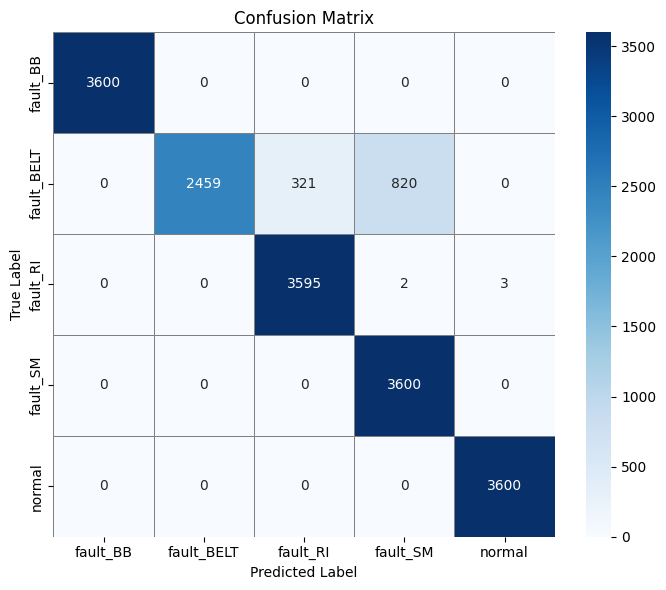

In [ ]:
# 혼동 행렬 시각화
label_encoder = LabelEncoder()
label_encoder.fit(categories)
plot_confusion_matrix(test_conf_matrix, label_encoder)

In [ ]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

# FLOPs 계산 함수
def calculate_flops(model, input_size):
    model.eval()  # 평가 모드로 전환
    dummy_input = torch.randn(*input_size).to(device)  # 가짜 입력 생성
    flops = FlopCountAnalysis(model, dummy_input)
    return flops

# 입력 크기 정의 (배치 크기, 채널, 길이)
input_size = (1, 1, input_length)  # 배치 크기 1, 채널 1, input_length 사용

# FLOPs 계산
flops = calculate_flops(model, input_size)

# 결과 출력
print(f"Total FLOPs: {flops.total() / 1e6:.2f} MFLOPs")  # FLOPs를 MegaFLOPs 단위로 변환
print(flop_count_table(flops))

Total FLOPs: 2.42 MFLOPs
| module         | #parameters or shape   | #flops   |
|:---------------|:-----------------------|:---------|
| model          | 0.126M                 | 2.425M   |
|  conv1         |  52                    |  58.422K |
|   conv1.weight |   (13, 1, 3)           |          |
|   conv1.bias   |   (13,)                |          |
|  conv2         |  1K                    |  0.73M   |
|   conv2.weight |   (25, 13, 3)          |          |
|   conv2.bias   |   (25,)                |          |
|  conv3         |  4.104K                |  1.515M  |
|   conv3.weight |   (54, 25, 3)          |          |
|   conv3.bias   |   (54,)                |          |
|  fc1           |  0.121M                |  0.121M  |
|   fc1.weight   |   (12, 10098)          |          |
|   fc1.bias     |   (12,)                |          |
|  bn1           |  24                    |  24      |
|   bn1.weight   |   (12,)                |          |
|   bn1.bias     |   (12,)              

In [ ]:
print("\nCalculating F1 Score...")
calculate_f1_score(model, test_loader, device)


Calculating F1 Score...
F1 Score: 0.9331


In [ ]:
# 파라미터 수 계산 함수
def calculate_total_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")

In [ ]:
print("\nCalculating Total Parameters...")
calculate_total_params(model)


Calculating Total Parameters...
Total Parameters: 126,433


In [ ]:
# 자원 제한 설정 함수
def setup_limited_resources(cpu_only=True, num_threads=2):
    if cpu_only:
        device = torch.device("cpu")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # CPU 환경일 경우 스레드 수 제한
    if device.type == "cpu":
        torch.set_num_threads(num_threads)
        print(f"CPU 환경: 스레드 수를 {num_threads}개로 제한합니다.")
    else:
        print(f"GPU 환경: {torch.cuda.get_device_name(0)} 사용 중.")

    return device

In [ ]:
# 추론 시간 측정 함수
def measure_inference_time(model, input_data, device, iterations=100):
    model.eval()
    model.to(device)
    input_data = input_data.to(device)

    # 추론 시간 측정
    with torch.no_grad():
        start_time = time.time()
        for _ in range(iterations):
            _ = model(input_data)
        end_time = time.time()

    avg_time = (end_time - start_time) / iterations
    print(f"Average Inference Time: {avg_time * 1000:.2f} ms")
    return avg_time

In [ ]:
# 1. 모델 저장
torch.save(model, "trained_model.pth")
print("Model saved as 'trained_model.pth'")

# 2. CPU 환경 설정
device_cpu = setup_limited_resources(cpu_only=True, num_threads=2)

# 3. 모델 로드
model = torch.load("trained_model.pth", map_location=device_cpu, weights_only=False)
model.to(device_cpu)
model.eval()
print("Model loaded and moved to CPU.")

Model saved as 'trained_model.pth'
CPU 환경: 스레드 수를 2개로 제한합니다.
Model loaded and moved to CPU.


In [ ]:
# 데이터 로더에서 샘플 데이터 가져오기
for input_data, _ in test_loader:
    break  # 첫 번째 배치만 가져옴

# 배치에서 첫 번째 샘플 선택 (배치 크기 1로 설정)
input_data = input_data[0:1].to(device_cpu)

In [ ]:
# 5. 제한된 환경에서 추론 시간 측정
print("\nMeasuring Inference Time on CPU...")
measure_inference_time(model, input_data, device_cpu, iterations=100)


Measuring Inference Time on CPU...
Average Inference Time: 0.90 ms


0.0008958673477172851